In [1]:
# load product data
products <- read.csv('/home/rubione/work/public/data/products.csv')
print(dim(products))
head(products)

[1] 52843     7


product_id,price,brand_id,division,category,subcategory,fineline
42879,10,359,15,11,46,6f1ba46da1abfd8fa10ad4055427ebe1
24926,9,70,15,11,46,dcda54e29207294d8e7e1b537338b1c0
34251,13,213,15,11,46,d799ddd9de9cc9964d5e0d936d6f284d
1410,6,80,15,11,46,943bbfd3b1b538841834b5fe8f3f18ff
12491,28,32,15,11,46,b4b5b5ca5d5fc4e8fe2f24c655cec987
49548,19,349,15,11,46,f6a7bf0dd91a7349da4c2fb95cb61b1f


In [2]:
# load customer data
customers <- read.csv('/home/rubione/work/public/data/customers.csv')
print(dim(customers))
head(customers)

[1] 1000000       2


customer_id,registration_date
25540437,2007-09-28 00:00:00
13979277,2007-10-07 00:00:00
25381493,2007-10-07 00:00:00
41970813,2007-10-07 00:00:00
24930117,2007-10-07 00:00:00
39871125,2007-10-07 00:00:00


In [3]:
# installed.packages()[, c(1, 3)]
# dir.create('UserLibrary')
.libPaths( c( .libPaths(), 'UserLibrary') )
# install.packages('forcats', lib='UserLibrary')
# install.packages('forecast', lib='UserLibrary')
tail(installed.packages(), n=1)
library(dplyr)
library(lubridate)
library(tidyr)
library(forecast)
library(forcats)

,Package,LibPath,Version,Priority,Depends,Imports,LinkingTo,Suggests,Enhances,License,License_is_FOSS,License_restricts_use,OS_type,MD5sum,NeedsCompilation,Built
zoo,zoo,/home/rubione/work/private/UserLibrary,1.8-1,NA,"R (>= 2.10.0), stats","utils, graphics, grDevices, lattice (>= 0.20-27)",NA,"coda, chron, DAAG, fts, ggplot2, mondate, scales, strucchange, timeDate, timeSeries, tis, tseries, xts",NA,GPL-2 | GPL-3,NA,NA,NA,NA,yes,3.3.3



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date



In [4]:
# load transaction data
transactions <- read.csv('/home/rubione/work/public/data/transactions.csv') %>% 
    mutate(transaction_date=parse_date_time(transaction_date, orders='ymd HMS'))
print(dim(transactions))
head(transactions)

[1] 18242155        6


customer_id,product_id,sale_id,transaction_date,product_quantity,product_price
19598045,29894,b376bf141dbadfee5c9f53b33cbe39ac,2009-12-21,1,4
39801397,30483,d0a12cc99c7fec2380e8781416a1403c,2009-12-14,1,7
49744497,30678,bf6bc6d2d575a4f17c0e82efe29a7585,2009-10-12,1,6
24637068,23630,27aa9ff7c603fdd379dc41c33fd8af3c,2009-03-09,1,5
24911294,14004,867718a9254e735f6416975df4131462,2010-05-30,1,17
42953928,23069,32df6aadce7ac5b2bb052a9bb5fe2c3f,2010-06-06,1,9


In [5]:
# develop a function to extract rfm
extract_rfm <- function(transactions, customers){
transactions %>% 
mutate(dtdiff=as.numeric(difftime(max(transaction_date), transaction_date, units='days'))) %>%
group_by(customer_id) %>% 
summarise(
    recency=360 - max(dtdiff),
    frequency=n(),
    monetary=sum(product_price),
) %>%
mutate(
    recency=ntile(recency, 10), 
    frequency=ntile(frequency, 10),
    monetary=ntile(monetary, 10)
) %>%
right_join(customers, by='customer_id') %>%
select(customer_id, recency, frequency, monetary) %>%
mutate_if(is.numeric , replace_na, replace = 0)}

In [6]:
# seperate transaction data into training data and test data
print(paste("Start at", min(transactions$transaction_date), "until", max(transactions$transaction_date)))
train_txns <- transactions %>% filter(transaction_date >= '2009-01-01' & transaction_date < '2010-01-01')
test_txns <- transactions %>% filter(transaction_date >= '2010-01-01' & transaction_date < '2010-02-01')

[1] "Start at 2009-01-05 until 2010-12-26"


In [7]:
print('Train: ')
print(paste(' * rows:', dim(train_txns)[1]))
print(paste(' * min date:', min(train_txns$transaction_date)))
print(paste(' * max date:', max(train_txns$transaction_date)))

print('Test: ')
print(paste(' * rows:', dim(test_txns)[1]))
print(paste(' * min date:', min(test_txns$transaction_date)))
print(paste(' * max date:', max(test_txns$transaction_date)))

[1] "Train: "
[1] " * rows: 6978669"
[1] " * min date: 2009-01-05"
[1] " * max date: 2009-12-28"
[1] "Test: "
[1] " * rows: 699979"
[1] " * min date: 2010-01-04"
[1] " * max date: 2010-01-25"


In [8]:
# develop RFM model
features = extract_rfm(train_txns, customers)
head(features)

customer_id,recency,frequency,monetary
25540437,6,9,10
13979277,6,8,7
25381493,1,10,10
41970813,3,8,10
24930117,1,10,10
39871125,9,2,1


In [9]:
avg.r = mean(features$recency)
avg.f = mean(features$frequency)
avg.m = mean(features$monetary)

In [10]:
# divide customer segments according to RFM model
features =
features%>% 
mutate(r = ifelse(recency >= avg.r,1,0), f = ifelse(frequency >= avg.f,1,0), m = ifelse(monetary >= avg.m,1,0))
features = 
features%>% 
mutate(rfm = r*100+f*10+m)
features =
features%>% 
mutate(group = ifelse(rfm==111,1,ifelse(rfm==11,2,ifelse(rfm==101,3,ifelse(rfm==1,4,ifelse(rfm==110,5,ifelse(rfm==100,6,ifelse(rfm==10,7,8))))))))
head(features)

customer_id,recency,frequency,monetary,r,f,m,rfm,group
25540437,6,9,10,1,1,1,111,1
13979277,6,8,7,1,1,1,111,1
25381493,1,10,10,0,1,1,11,2
41970813,3,8,10,1,1,1,111,1
24930117,1,10,10,0,1,1,11,2
39871125,9,2,1,1,0,0,100,6


In [11]:
# see the composition of "basket value"
aggregate(customer_id~group,features,FUN = function(x) length(unique(x)))

group,customer_id
1,300467
2,100240
3,32915
4,2044
5,32261
6,70023
7,2698
8,459352


In [12]:
# use time series model to forecast the future trend for each group
timeseries = aggregate(product_price ~ transaction_date + customer_id,train_txns,sum)
timeseries = features[,c(1,9)] %>%  
left_join(timeseries,by = 'customer_id')
dim(timeseries)
timeseries = aggregate(product_price ~ group + transaction_date,timeseries,mean) 
dim(timeseries)

[1] 2665383       4

[1] 404   3

In [13]:
# use test data time series to test those model
timeseries.t = aggregate(product_price ~ transaction_date + customer_id,test_txns,sum)
timeseries.t = features[,c(1,9)] %>%  
left_join(timeseries.t,by = 'customer_id')
dim(timeseries.t)
timeseries.t = aggregate(product_price ~ group + transaction_date,timeseries.t,mean) 
dim(timeseries.t)

[1] 1032082       4

[1] 32  3

In [14]:
# take group 4 as an example
timeseries4 = subset(timeseries,group == 4)
dim(timeseries4)
ts4 <- ts(timeseries4$product_price,frequency = 52)

[1] 52  3

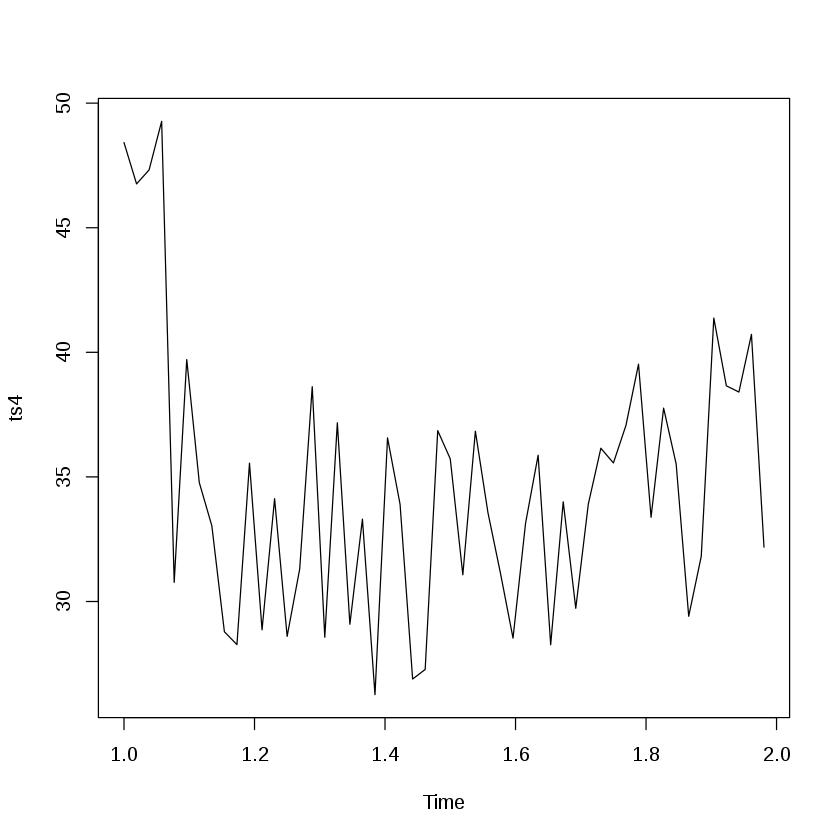

Series: ts4 
ARIMA(3,1,1) 

Coefficients:
          ar1      ar2      ar3     ma1
      -1.6615  -0.9508  -0.2882  0.9926
s.e.   0.1412   0.2355   0.1383  0.0647

sigma^2 estimated as 25.07:  log likelihood=-152.82
AIC=315.64   AICc=316.97   BIC=325.3

Training set error measures:
                     ME     RMSE      MAE       MPE     MAPE MASE        ACF1
Training set -0.4589151 4.759855 3.808879 -2.590482 11.63368  NaN -0.04817685


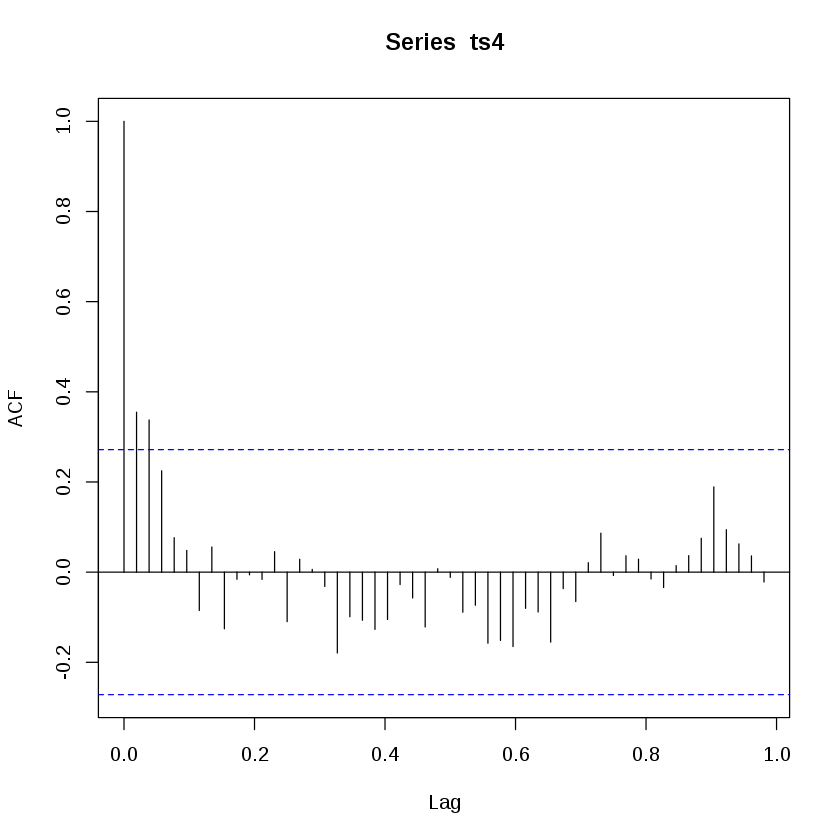

In [15]:
plot(ts4)
acf(ts4, lag = 52)
ARMA4 = Arima(ts4,order=c(3,1,1))
summary(ARMA4)

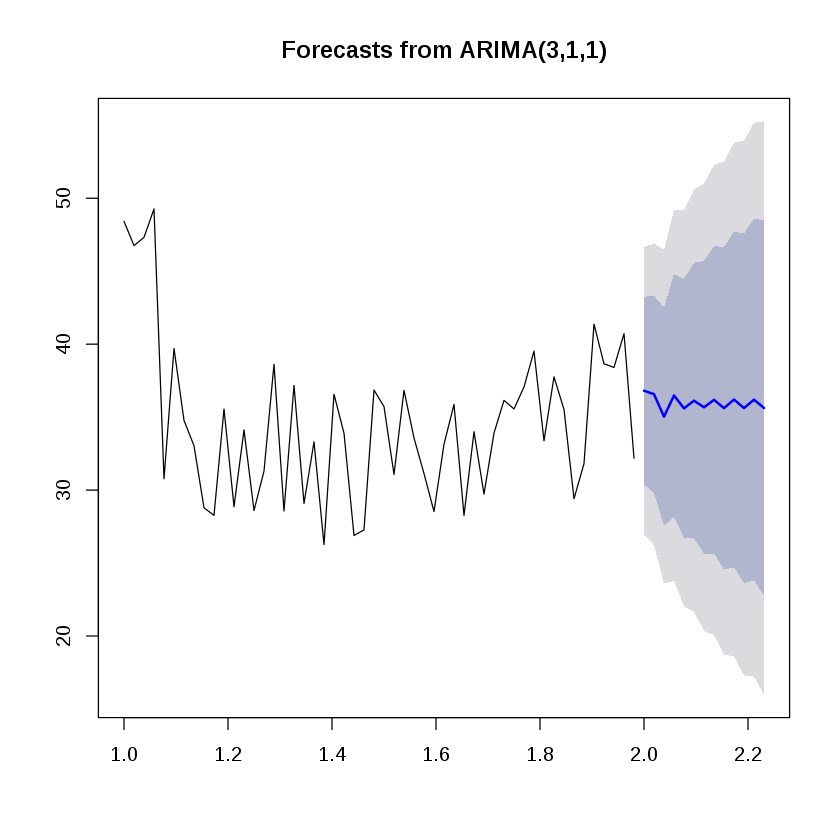

In [16]:
plot(forecast(ARMA4,h=13))

In [17]:
# use test data to see how well the model does
test4 = subset(timeseries.t,group == 4)
mse4<-mean((forecast(ARMA4,h=52)$mean-test4$product_price)^2)
mse4

[1] 256.1731

In [18]:
# use the arima model and whole transaction data to forecast the future spending trend of each group
final <- transactions %>% filter(transaction_date >= '2010-01-01' )
t.n =
final %>% 
group_by(transaction_date,customer_id) %>% 
summarise(
    product_price = sum(product_price)
)%>% 
right_join(features[,c(1,9)],by = 'customer_id')
t.n = 
t.n %>% 
group_by(group, transaction_date) %>% 
summarise(
    product_price = mean(product_price)
)
head(t.n)

group,transaction_date,product_price
1,2010-01-04,52.40215
1,2010-01-11,53.16069
1,2010-01-18,52.28424
1,2010-01-25,54.78399
1,2010-02-01,55.59806
1,2010-02-08,57.09950


Time Series:
Start = c(5, 1) 
End = c(5, 13) 
Frequency = 13 
 [1] 50.25360 50.34748 50.28647 50.14277 49.98702 50.00367 49.87179 50.39514
 [9] 50.03434 50.38805 50.34689 50.01664 49.92181

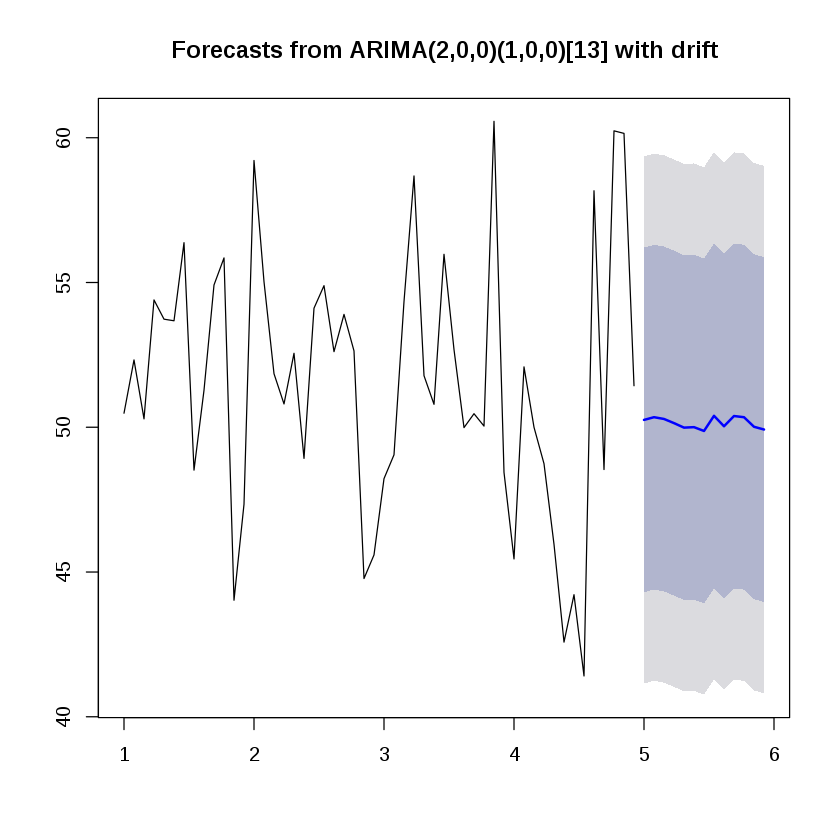

In [19]:
# take group 4 as an example
t.4 = subset(t.n,group == 4)
ARIMA4 = Arima(ts(t.4$product_price,frequency = 13),order=c(2,0,0),seasonal=c(1,0,0),include.drift=TRUE)
forecast(ARIMA4,h=13)$mean
plot(forecast(ARIMA4,h=13))

In [20]:
# calculate the churn rate of each group
# find the endday of each customer
endday = 
transactions %>%
group_by(customer_id) %>% 
summarise(
    endday = max(transaction_date)
)

In [21]:
# find the startday of each customer
customerbehaviour =
transactions %>% 
group_by(transaction_date,customer_id) %>% 
summarise(
    startday = min(transaction_date)
)%>% 
right_join(features[,c(1,9)],by = 'customer_id')
customerbehaviour =
customerbehaviour%>% 
right_join(endday,by = 'customer_id')
head(customerbehaviour)

transaction_date,customer_id,startday,group,endday
2009-05-25,15855,2009-05-25,1,2010-06-13
2010-06-13,15855,2010-06-13,1,2010-06-13
2009-07-06,16148,2009-07-06,1,2010-09-05
2010-03-21,16148,2010-03-21,1,2010-09-05
2010-09-05,16148,2010-09-05,1,2010-09-05
2009-07-06,16209,2009-07-06,6,2010-08-15


In [22]:
# the interval between the startday and enday is the customer active period
customerbehaviour$startday<-as.Date(customerbehaviour$startday)
customerbehaviour$period<-difftime(customerbehaviour$endday,customerbehaviour$startday,units='week')
customerbehaviour$period[customerbehaviour$endday>='2010-12-05']<-NA
customerbehaviour$period<-as.numeric(customerbehaviour$period)
customerbehaviour$weeklychurn<-1/customerbehaviour$period
customerbehaviour$weeklychurn[is.infinite(customerbehaviour$weeklychurn)==T]<-1
customerbehaviour$weeklychurn[is.na(customerbehaviour$weeklychurn)==T]<-0
head(customerbehaviour)

transaction_date,customer_id,startday,group,endday,period,weeklychurn
2009-05-25,15855,2009-05-25,1,2010-06-13,54.85714,0.01822917
2010-06-13,15855,2010-06-13,1,2010-06-13,0.00000,1.00000000
2009-07-06,16148,2009-07-06,1,2010-09-05,60.85714,0.01643192
2010-03-21,16148,2010-03-21,1,2010-09-05,24.00000,0.04166667
2010-09-05,16148,2010-09-05,1,2010-09-05,0.00000,1.00000000
2009-07-06,16209,2009-07-06,6,2010-08-15,57.85714,0.01728395


In [23]:
# use the average churn rate of customers in each group as group churn rate
groupchurn =
customerbehaviour %>%
group_by(group) %>% 
summarise(
    churn = mean(weeklychurn)
)
groupchurn

group,churn
1,0.09216434
2,0.05061376
3,0.23237120
4,0.22741852
5,0.18406735
6,0.24847166
7,0.18350955
8,0.40901138


In [24]:
# forecast the purchase interval of each group
df<-transactions%>%  
    right_join(features[,c(1,9)], by = "customer_id")
head(df)

customer_id,product_id,sale_id,transaction_date,product_quantity,product_price,group
25540437,26644,29dd474e9b72a3413a24a7465d1b4715,2009-06-22,1,12,1
25540437,29158,29dd474e9b72a3413a24a7465d1b4715,2009-06-22,1,8,1
25540437,4758,aa3ecd3d10d0d5084c30f96ac40df919,2010-06-27,1,8,1
25540437,28516,29dd474e9b72a3413a24a7465d1b4715,2009-06-22,1,13,1
25540437,5927,47750db10a7ffd8b81590af7037fa5f3,2009-11-16,1,31,1
25540437,30673,aa3ecd3d10d0d5084c30f96ac40df919,2010-06-27,1,16,1


In [25]:
# take group 4 as an example
group4<-df %>% filter(group == 4)
group4<-group4[ ,c(1,4)]
head(group4)

customer_id,transaction_date
36770037,2010-08-29
36770037,2010-10-31
36770037,2009-01-19
36770037,2010-07-04
36770037,2010-12-05
36770037,2010-04-11


In [26]:
group4<-group4 %>%
  group_by(customer_id, transaction_date) %>%
  filter(row_number() == 1) %>%
  ungroup()
group4<-group4 %>%
  arrange(customer_id,transaction_date) %>%
  select(customer_id,transaction_date)
a<-c()
for (i in 2:nrow(group4)){
    a[i]<-difftime(group4$transaction_date[i],group4$transaction_date[i-1])
}
group4$diff<-a

In [27]:
index<-function(x){return(c(1:length(x)))}
group4<-transform(group4,times=unlist(tapply(diff,customer_id,index)))
average_daygroup4 = aggregate(diff~times,data=group4,mean,na.rm=T)
average_daygroup4

times,diff
1,-578.96427
2,320.42412
3,213.29611
4,116.55040
5,74.44237
6,69.75232
7,49.79894
8,41.25962
9,36.35088
10,37.60000


In [28]:
model4<-auto.arima(average_daygroup4$diff[2:30],D=0,seasonal = FALSE,approximation=FALSE)

Time Series:
Start = 18 
End = 19 
Frequency = 1 
[1] 367.5 392.0

[1] NA

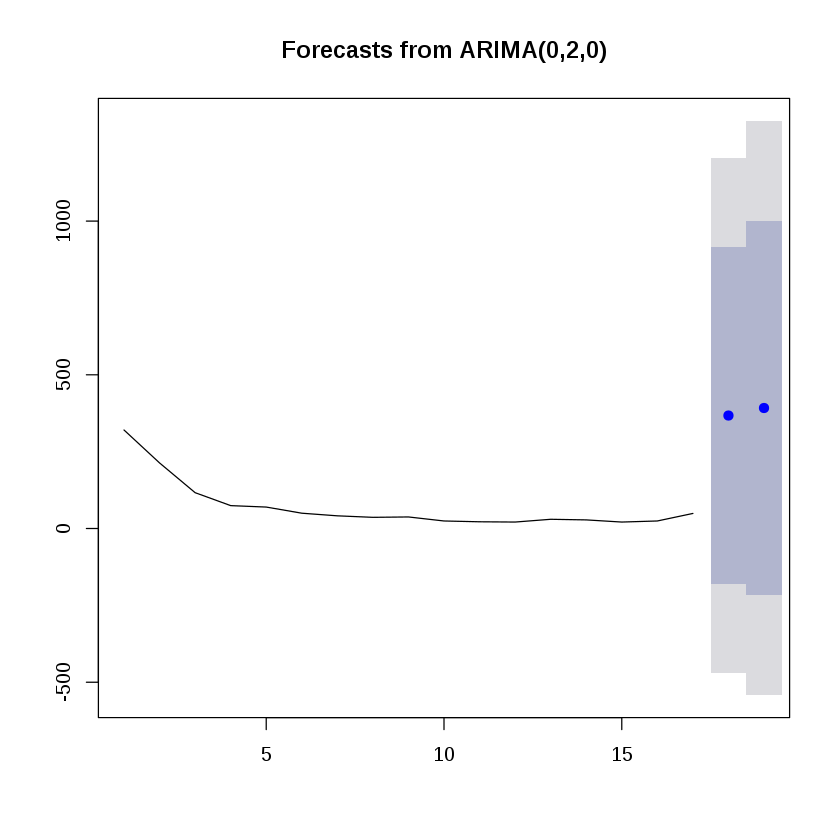

In [29]:
predictedValues4 =forecast(model4,h=2)$mean
predictedValues4
mean(((predictedValues4-average_daygroup4$diff[31:32])^2))
plot(forecast(model4,h=2))

In [30]:
## Join df table with products table
df1<-df %>%  
    left_join(products, by = "product_id")
head(df1)

customer_id,product_id,sale_id,transaction_date,product_quantity,product_price,group,price,brand_id,division,category,subcategory,fineline
25540437,26644,29dd474e9b72a3413a24a7465d1b4715,2009-06-22,1,12,1,19,51,16,6,29,8d8f94d011cbf171554301e02175b07f
25540437,29158,29dd474e9b72a3413a24a7465d1b4715,2009-06-22,1,8,1,10,266,6,7,34,4c8ff3e9973038be427075323dd98ac2
25540437,4758,aa3ecd3d10d0d5084c30f96ac40df919,2010-06-27,1,8,1,8,217,16,19,11,0d4fa663fa7c7d42030b83ffa7bc2de3
25540437,28516,29dd474e9b72a3413a24a7465d1b4715,2009-06-22,1,13,1,13,25,16,16,37,7386508a5babe85132d1008d6f74d7c8
25540437,5927,47750db10a7ffd8b81590af7037fa5f3,2009-11-16,1,31,1,31,370,16,17,38,372d5b376539a64a8351f49e4d70950e
25540437,30673,aa3ecd3d10d0d5084c30f96ac40df919,2010-06-27,1,16,1,16,446,7,13,32,9a7e3dcfd77a3cecfc6476f5b7862986


In [31]:
## Build a table to show total sales of each brand in each group
bgroup<-df1 %>% 
group_by(group,brand_id)%>%
summarise(n=sum(product_price)) %>% 
select(group,brand_id,n)

In [32]:
## Find each group's favorite brand
brand1<-bgroup %>% 
group_by(group)%>%
summarise(brand=brand_id[which.max(n)]) %>% 
select(group,d=brand) 
print(brand1)

# A tibble: 8 x 2
  group     d
  <dbl> <int>
1    1.    26
2    2.    26
3    3.    26
4    4.   124
5    5.   254
6    6.    26
7    7.   254
8    8.    26


In [33]:
## join products and transactions table
df2<-left_join(train_txns,products,by="product_id")

In [34]:
## join products and transactions table to find whether customers will buy a certain brand in the next month
after<-left_join(test_txns,products,by="product_id") 

In [35]:
## Build a new table contains sales of brand26 for each customer
brand26<-after %>% 
group_by(customer_id)%>%
summarise(brandn=sum(product_price[brand_id==26])) %>% 
select(customer_id,brandn)

In [36]:
## Add a new column that represents whether an individual buys brand26
brand26<-brand26 %>% 
mutate(buy=ifelse(brandn>0&!is.na(brandn),1,0))  

In [37]:
## Build a new table that contains sales of each category for each customer
cper<-df2 %>% 
group_by(customer_id,category)%>%
summarise(n=sum(product_price)) %>% 
select(customer_id,category,n) 
head(cper) 

customer_id,category,n
15855,6,29
15855,11,17
15855,17,25
15855,20,65
15855,24,35
16148,6,26


In [38]:
## Reshape the table to spread values in the category to columns and represent the number using binary value
cper1<-cper %>% 
spread(category,n)   
cper1[is.na(cper1)]<-0 
for(i in 2:26){ 
cper1[i]=ifelse(cper1[i]>0,1,0) 
}
head(cper1)

customer_id,1,2,3,4,5,6,7,8,9,⋯,16,17,18,19,20,21,22,23,24,25
15855,0,0,0,0,0,1,0,0,0,⋯,0,1,0,0,1,0,0,0,1,0
16148,0,0,0,0,0,1,0,0,0,⋯,0,0,0,0,1,0,0,0,1,0
16209,0,0,0,0,0,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
16240,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
16255,0,0,0,0,0,0,0,0,0,⋯,0,0,0,1,0,0,0,0,0,0
16295,0,0,0,0,0,1,0,0,0,⋯,0,0,0,1,1,0,0,0,0,0


In [39]:
## Join category and brand tables
df_brand<-left_join(brand26,cper1,by="customer_id") 
for (i in 4:28){ 
names(df_brand)[i]<-paste0("category",i-3) 
}  
head(df_brand)

customer_id,brandn,buy,category1,category2,category3,category4,category5,category6,category7,⋯,category16,category17,category18,category19,category20,category21,category22,category23,category24,category25
16526,0,0,0,0,1,0,0,1,0,⋯,0,1,0,0,1,0,0,0,0,0
16601,0,0,0,0,0,0,0,1,0,⋯,0,0,0,0,1,0,0,0,1,0
17194,0,0,0,0,0,1,0,0,0,⋯,0,0,0,0,1,0,0,0,1,1
17683,0,0,1,0,0,0,0,1,0,⋯,0,0,0,0,0,0,0,0,1,0
19085,0,0,0,0,1,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
19500,0,0,1,0,1,0,1,0,1,⋯,1,1,0,1,1,0,1,0,1,0


In [40]:
## Build logistic model
model<-glm(as.formula(paste0("buy~",paste0(names(df_brand)[4:28],collapse = "+"))),data=df_brand,family=binomial) 

In [41]:
## model summary
summary(model)


Call:
glm(formula = as.formula(paste0("buy~", paste0(names(df_brand)[4:28], 
    collapse = "+"))), family = binomial, data = df_brand)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.8933  -0.4697  -0.4045  -0.3405   2.6732  

Coefficients:
            Estimate Std. Error  z value Pr(>|z|)    
(Intercept) -2.96595    0.02541 -116.737  < 2e-16 ***
category1    0.18615    0.02014    9.243  < 2e-16 ***
category2    0.23444    0.02055   11.409  < 2e-16 ***
category3   -0.07791    0.02269   -3.434 0.000594 ***
category4    0.25365    0.02152   11.788  < 2e-16 ***
category5   -0.06010    0.02274   -2.643 0.008228 ** 
category6   -0.13260    0.01999   -6.635 3.24e-11 ***
category7   -0.09118    0.02387   -3.819 0.000134 ***
category8   -0.05644    0.02772   -2.036 0.041712 *  
category9    0.07016    0.02822    2.486 0.012902 *  
category10  -0.05067    0.02166   -2.339 0.019325 *  
category11   0.09784    0.02004    4.882 1.05e-06 ***
category12  -0.02266    0.02454 

In [42]:
## Build a new table contains sales of brand124 for each customer
brand124<-after %>% 
group_by(customer_id)%>%
summarise(brandn=sum(product_price[brand_id==124])) %>% 
select(customer_id,brandn)

In [43]:
## Add a new column that represents whether an individual buys brand124
brand124<-brand124 %>% 
mutate(buy=ifelse(brandn>0&!is.na(brandn),1,0)) 

In [44]:
## Join category and brand tables
df_brand1<-left_join(brand124,cper1,by="customer_id") 
for (i in 4:28){ 
names(df_brand1)[i]<-paste0("category",i-3) 
}  
head(df_brand1)

customer_id,brandn,buy,category1,category2,category3,category4,category5,category6,category7,⋯,category16,category17,category18,category19,category20,category21,category22,category23,category24,category25
16526,0,0,0,0,1,0,0,1,0,⋯,0,1,0,0,1,0,0,0,0,0
16601,0,0,0,0,0,0,0,1,0,⋯,0,0,0,0,1,0,0,0,1,0
17194,0,0,0,0,0,1,0,0,0,⋯,0,0,0,0,1,0,0,0,1,1
17683,0,0,1,0,0,0,0,1,0,⋯,0,0,0,0,0,0,0,0,1,0
19085,0,0,0,0,1,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
19500,0,0,1,0,1,0,1,0,1,⋯,1,1,0,1,1,0,1,0,1,0


In [45]:
## Build logistic model
model1<-glm(as.formula(paste0("buy~",paste0(names(df_brand1)[4:28],collapse = "+"))),data=df_brand1,family=binomial) 
summary(model1)


Call:
glm(formula = as.formula(paste0("buy~", paste0(names(df_brand1)[4:28], 
    collapse = "+"))), family = binomial, data = df_brand1)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.7029  -0.4794  -0.4020  -0.2964   2.8182  

Coefficients:
             Estimate Std. Error  z value Pr(>|z|)    
(Intercept) -2.906321   0.025979 -111.873  < 2e-16 ***
category1    0.227780   0.020981   10.856  < 2e-16 ***
category2   -0.042531   0.022328   -1.905  0.05680 .  
category3   -0.048302   0.024049   -2.009  0.04459 *  
category4   -0.014108   0.023980   -0.588  0.55630    
category5   -0.242955   0.024750   -9.817  < 2e-16 ***
category6   -0.063660   0.020551   -3.098  0.00195 ** 
category7   -0.003051   0.025051   -0.122  0.90306    
category8    0.005854   0.029164    0.201  0.84091    
category9    0.119622   0.030105    3.973 7.08e-05 ***
category10  -0.031076   0.022887   -1.358  0.17452    
category11  -0.283341   0.020588  -13.763  < 2e-16 ***
category12  -0.03

In [46]:
# Delete columes not contorlled in prediction. # Build complete dataframe
transaction <- transactions[,-3] 
transaction[1,]
product <- products[,-c(4,6,7)]  
head(product)
group <- features[,c(1,9)] 
head(group)

customer_id,product_id,transaction_date,product_quantity,product_price
19598045,29894,2009-12-21,1,4


product_id,price,brand_id,category
42879,10,359,11
24926,9,70,11
34251,13,213,11
1410,6,80,11
12491,28,32,11
49548,19,349,11


customer_id,group
25540437,1
13979277,1
25381493,2
41970813,1
24930117,2
39871125,6


In [47]:
df <- left_join(transaction, product, by = "product_id")  
head(df)

customer_id,product_id,transaction_date,product_quantity,product_price,price,brand_id,category
19598045,29894,2009-12-21,1,4,4,148,10
39801397,30483,2009-12-14,1,7,7,254,11
49744497,30678,2009-10-12,1,6,16,213,12
24637068,23630,2009-03-09,1,5,8,301,18
24911294,14004,2010-05-30,1,17,18,1,11
42953928,23069,2010-06-06,1,9,9,70,20


In [48]:
df <- left_join(df, group, by = "customer_id")  
df <- df[,-c(6,10)]
head(df)

customer_id,product_id,transaction_date,product_quantity,product_price,brand_id,category,group
19598045,29894,2009-12-21,1,4,148,10,2
39801397,30483,2009-12-14,1,7,254,11,1
49744497,30678,2009-10-12,1,6,213,12,2
24637068,23630,2009-03-09,1,5,301,18,5
24911294,14004,2010-05-30,1,17,1,11,8
42953928,23069,2010-06-06,1,9,70,20,1


In [49]:
# Because of the size of the dataset is too huge to compute, we decided to
set.seed(123)
df_customer <- unique(df$customer_id)
df_customer <- df_customer[sample(1:length(df_customer), length(df_customer)*0.3)]

In [50]:
df_sample <- df[df$customer_id %in% df_customer,] 
head(df_sample)

,customer_id,product_id,transaction_date,product_quantity,product_price,brand_id,category,group
3,49744497,30678,2009-10-12,1,6,213,12,2
5,24911294,14004,2010-05-30,1,17,1,11,8
7,48731623,31769,2010-07-04,1,22,133,5,1
11,45246564,50763,2009-05-25,1,5,158,3,2
14,25459625,31827,2010-11-07,1,24,123,20,1
15,25167301,3570,2009-08-31,1,19,86,6,1


In [51]:
# Calculate the average amount each customer spent on each category.
df_sample.1 <- df_sample %>% filter(transaction_date >= '2009-01-01' & transaction_date < '2010-07-11')
df.2 <- aggregate(product_price~ customer_id + category, df_sample.1, mean)
head(df.2)

customer_id,category,product_price
16518,1,41.0
17111,1,30.0
17388,1,11.0
17683,1,17.0
18853,1,75.5
19500,1,22.0


In [52]:
table(df.2$category)/nrow(df.2)*100
# category 20 has the highest purchase rate : 192381


          1           2           3           4           5           6 
 5.02234791  4.09246588  4.33288314  3.26563048  4.07545311  7.53978973 
          7           8           9          10          11          12 
 3.11221711  2.55669057  1.65352157  3.76452241  7.28825448  2.93410537 
         13          14          15          16          17          18 
 2.30702075  3.20526500  5.02980965  3.04558377  7.11387361  1.42078990 
         19          20          21          22          23          24 
 3.79593634 11.10075587  0.06782722  1.40109091  0.17676862  9.87971675 
         25 
 1.81767985 

In [53]:
library(reshape)


Attaching package: ‘reshape’

The following objects are masked from ‘package:tidyr’:

    expand, smiths

The following object is masked from ‘package:lubridate’:

    stamp

The following object is masked from ‘package:dplyr’:

    rename



In [54]:
# reshape the data fram, turn categories into individual columes
df.3<-df.2 %>% 
spread(category,product_price) 
df.3[is.na(df.3)] <- 0
df.3 <- left_join(df.3, group, by = "customer_id")
head(df.3)

customer_id,1,2,3,4,5,6,7,8,9,⋯,17,18,19,20,21,22,23,24,25,group
16240,0,0,0.0,0,0,0,0,0,0,⋯,0,0,0.0,0.00000,0,0,0,0.0,0,6
16295,0,0,0.0,0,0,6,0,0,0,⋯,0,0,10.0,9.00000,0,0,0,0.0,0,1
16315,0,0,9.4,0,9,0,17,0,8,⋯,0,21,4.5,93.00000,0,0,0,5.0,0,2
16518,41,0,0.0,0,0,0,0,0,0,⋯,49,0,7.0,18.33333,0,0,0,32.4,0,1
16526,0,3,4.0,0,0,21,0,0,0,⋯,5,13,4.0,19.00000,0,0,0,11.5,0,1
17111,30,0,6.0,0,6,0,0,0,0,⋯,13,0,0.0,25.00000,0,0,0,0.0,0,1


In [55]:
# turn group into discrete variable
df.3$group <- as.factor(df.3$group)

In [58]:
df.7 <- df_sample %>% filter(transaction_date >= '2010-07-11' & transaction_date < '2010-12-12')  
head(df.7)

customer_id,product_id,transaction_date,product_quantity,product_price,brand_id,category,group
25459625,31827,2010-11-07,1,24,123,20,1
41367818,26232,2010-10-03,1,9,104,1,1
53475961,33882,2010-07-25,1,12,124,11,7
49233199,10395,2010-07-18,1,15,26,2,6
25191235,50655,2010-11-28,1,26,66,6,8
34972761,26028,2010-08-15,1,55,26,4,8


In [59]:
df.7<-cast(df.7,customer_id~category,value="product_price") 
head(df.7)

Aggregation requires fun.aggregate: length used as default


customer_id,1,2,3,4,5,6,7,8,9,⋯,17,18,19,20,21,22,23,24,25,26
16240,1,0,0,0,0,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
16295,0,0,0,0,0,1,0,0,0,⋯,0,0,1,2,0,0,0,0,0,0
16526,0,0,0,0,0,0,0,0,1,⋯,0,0,0,3,0,0,0,0,0,0
17282,0,0,0,0,0,0,0,0,0,⋯,0,0,0,1,0,0,0,0,0,0
17388,0,0,1,1,0,0,0,0,1,⋯,0,1,0,0,0,0,0,1,0,0
17683,1,0,0,0,0,0,0,0,0,⋯,0,0,0,2,0,0,0,0,0,0


In [61]:
df.3$purchase20 <- 0
df.3$purchase20[df.3$customer_id %in% unique(df.7$customer_id[df.7[,21] > 0])] <-1

In [62]:
head(df.3)

customer_id,1,2,3,4,5,6,7,8,9,⋯,18,19,20,21,22,23,24,25,group,purchase20
16240,0,0,0.0,0,0,0,0,0,0,⋯,0,0.0,0.00000,0,0,0,0.0,0,6,0
16295,0,0,0.0,0,0,6,0,0,0,⋯,0,10.0,9.00000,0,0,0,0.0,0,1,1
16315,0,0,9.4,0,9,0,17,0,8,⋯,21,4.5,93.00000,0,0,0,5.0,0,2,0
16518,41,0,0.0,0,0,0,0,0,0,⋯,0,7.0,18.33333,0,0,0,32.4,0,1,0
16526,0,3,4.0,0,0,21,0,0,0,⋯,13,4.0,19.00000,0,0,0,11.5,0,1,1
17111,30,0,6.0,0,6,0,0,0,0,⋯,0,0.0,25.00000,0,0,0,0.0,0,1,0


In [63]:
# normalize the data
df.3[,2:26] <- scale(df.3[,2:26])
head(df.3)

customer_id,1,2,3,4,5,6,7,8,9,⋯,18,19,20,21,22,23,24,25,group,purchase20
16240,-0.4815985,-0.3493718,-0.4430789,-0.3432145,-0.4055171,-0.6544809,-0.3287826,-0.3333427,-0.1876118,⋯,-0.2392538,-0.4187275,-0.90868618,-0.05767063,-0.196774,-0.08885119,-0.93184155,-0.2866298,6,0
16295,-0.4815985,-0.3493718,-0.4430789,-0.3432145,-0.4055171,-0.1810690,-0.3287826,-0.3333427,-0.1876118,⋯,-0.2392538,1.1947302,-0.03944117,-0.05767063,-0.196774,-0.08885119,-0.93184155,-0.2866298,1,1
16315,-0.4815985,-0.3493718,1.1207751,-0.3432145,0.8638368,-0.6544809,1.0474233,-0.3333427,0.4010589,⋯,4.5455033,0.3073285,8.07351223,-0.05767063,-0.196774,-0.08885119,-0.55951533,-0.2866298,2,0
16518,1.8717676,-0.3493718,-0.4430789,-0.3432145,-0.4055171,-0.6544809,-0.3287826,-0.3333427,-0.1876118,⋯,-0.2392538,0.7106929,0.86199810,-0.05767063,-0.196774,-0.08885119,1.48083240,-0.2866298,1,0
16526,-0.4815985,0.0276295,0.2223909,-0.3432145,-0.4055171,1.0024605,-0.3287826,-0.3333427,-0.1876118,⋯,2.7227387,0.2266556,0.92638662,-0.05767063,-0.196774,-0.08885119,-0.07549123,-0.2866298,1,1
17111,1.2403767,-0.3493718,0.5551258,-0.3432145,0.4407188,-0.6544809,-0.3287826,-0.3333427,-0.1876118,⋯,-0.2392538,-0.4187275,1.50588329,-0.05767063,-0.196774,-0.08885119,-0.93184155,-0.2866298,1,0


In [64]:
# set training data and test data
set.seed(123)
df_train <- df.3[sample(1:nrow(df.3), nrow(df.3)*0.7),] 
df_test <- df.3[-sample(1:nrow(df.3), nrow(df.3)*0.3),]

In [65]:
installed.packages()[,c(1,3)] 
.libPaths(c(.libPaths(),'UserLibrary')) 
install.packages('pscl', lib='UserLibrary')

,Package,Version
assertthat,assertthat,0.2.0
base64enc,base64enc,0.1-3
BH,BH,1.66.0-1
bindr,bindr,0.1.1
bindrcpp,bindrcpp,0.2.2
cli,cli,1.0.0
colorspace,colorspace,1.3-2
crayon,crayon,1.3.4
curl,curl,3.2
devtools,devtools,1.13.5


In [66]:
library('pscl')

Classes and Methods for R developed in the
Political Science Computational Laboratory
Department of Political Science
Stanford University
Simon Jackman
hurdle and zeroinfl functions by Achim Zeileis


In [ ]:
logModel <- glm(as.factor(purchase20) ~., df_train, family = binomial)

In [ ]:
summary(logModel)

In [ ]:
# predict the probability of purchasing Category 20
df_test$purchase20.prob <- predict(logModel, df_test, type = "resp")

In [ ]:
# if the probability > 50% we would assume the customer would buy.
df_test$purchase20.pred <- ifelse(df_test$purchase20.prob > 0.5, 1, 0)

In [ ]:
head(df_test)

In [ ]:
table(df_test$purchase20 == df_test$purchase20.pred)

In [ ]:
#accuracy 
sum(df_test$purchase20 == df_test$purchase20.pred,na.rm = T)/nrow(df_test)